<a href="https://colab.research.google.com/github/costanzagiacona/Progetto-ML/blob/main/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image classification**
Machine learning project for image classification using different types of models. I used 'MedMNIST-Pneumonia' data set for training.
The aim of this project is to train and evaluate one or more classification models in order to establish if the lungs in the images have pneumonia or not.

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.5 MB/s eta 0:00:00


Cell that groups all the libraries used for this project

In [ ]:
import numpy as np                           # For numerical operations
import pandas as pd                          # For data manipulation and analysis
import matplotlib.pyplot as plt              # For data visualization
import seaborn as sns                        # For enhanced data visualization
import time                                  # For timing operations
import random

# Imports for data manipulation and model preparation
from sklearn.model_selection import train_test_split, GridSearchCV     # For splitting data and hyperparameter tuning
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler        # For preprocessing data
from sklearn.impute import SimpleImputer                               # For handling missing values
from sklearn.pipeline import make_pipeline                             # For creating pipelines
from sklearn.compose import make_column_transformer                     # For transforming columns in datasets
from sklearn.model_selection import StratifiedShuffleSplit              # For stratified splitting of data
from sklearn.metrics import mean_squared_error, mean_absolute_error    # For model evaluation
from sklearn.linear_model import LinearRegression, LogisticRegression  # For linear and logistic regression
from sklearn.tree import DecisionTreeRegressor                         # For decision tree regression
from sklearn.neighbors import KNeighborsRegressor                      # For KNN regression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier  # For random forest models
from sklearn.svm import SVC                                           # For Support Vector Classifier
from sklearn.decomposition import PCA                                  # For Principal Component Analysis
from sklearn.metrics import accuracy_score                            # For accuracy
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

# Imports for visualization and presenting results
from IPython.display import Markdown, display                          # For displaying Markdown and results
import seaborn as sns                                                  # For advanced visualization
from pandas.plotting import scatter_matrix                             # For plotting scatter matrix
from glob import glob                                                  # For displaying images
from PIL import Image
import os
import cv2                                                             # For filtering images

# Imports for modeling with Keras
import tensorflow as tf                                                 # TensorFlow library
from tensorflow import keras                                            # Keras API for TensorFlow
import keras_tuner                                                      # Keras Tuner for hyperparameter tuning
from keras.models import Sequential                                     # For sequential models
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D  # For defining layers
from keras import regularizers
from keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

I loaded the dataset. The images are stored in the file 'pneumonia_images' and the labels in 'pneumonia_labels'.

In [ ]:
# Uploading dataset MedMNIST
try:
    X = np.load("/content/drive/MyDrive/pneumonia_images.npy")
    y = np.load("/content/drive/MyDrive/pneumonia_labels.npy")
except FileNotFoundError:
    print("File not found. Make sure you have the correct path")
    exit()

This code snippet counts the number of normal and pneumonia images, displays a sample of each class, and shows the class distribution.

Image shape: (28, 28)
Total normal images: 1349
Total pneumonia images: 3883


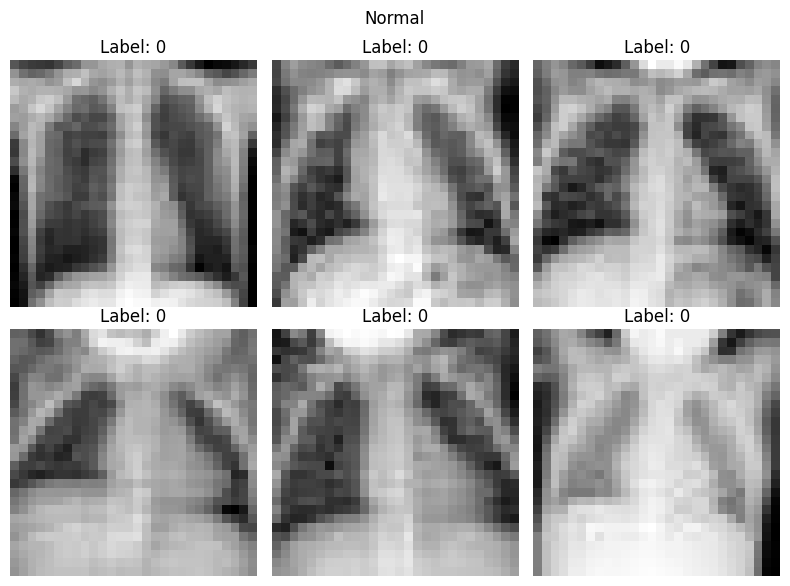

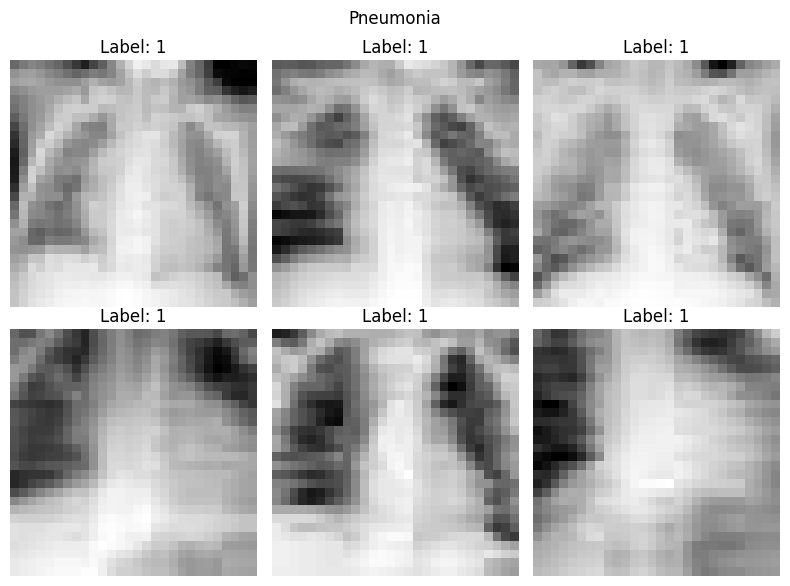

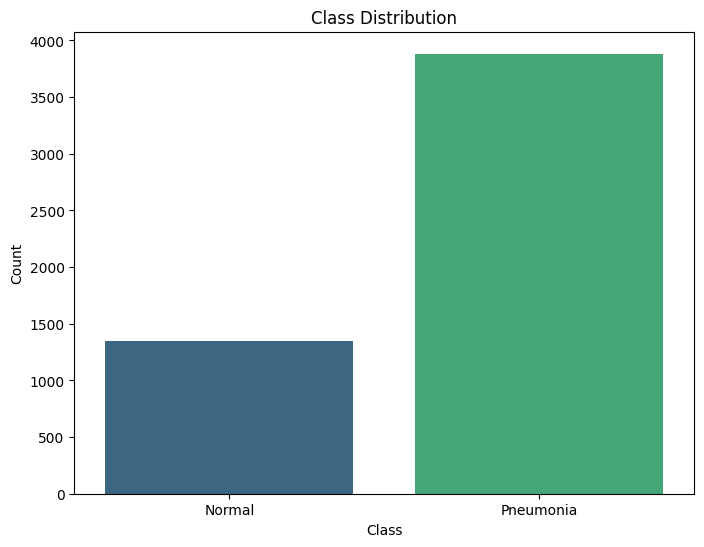

In [ ]:
# Check the resolution of images
print(f'Image shape: {X[0].shape}')

# Count the number of images in each class
normal_images_count = np.sum(y == 0)
pneumonia_images_count = np.sum(y == 1)

print(f'Total normal images: {normal_images_count}')
print(f'Total pneumonia images: {pneumonia_images_count}')

# Function to display some images
def show_images(images, labels, label, title):
    plt.figure(figsize=(8,6))
    indices = np.where(labels == label)[0][:6]  # Get the first 6 indices of the specified label
    for i, idx in enumerate(indices):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.axis('off')
        plt.title(f'Label: {label}')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Display some normal images
show_images(X, y, 0, 'Normal')

# Display some pneumonia images
show_images(X, y, 1, 'Pneumonia')

# Distribution of classes
labels = ['Normal', 'Pneumonia']
counts = [normal_images_count, pneumonia_images_count]
data = pd.DataFrame({'Class': labels, 'Count': counts})

plt.figure(figsize=(8, 6))
sns.barplot(x='Class', y='Count', data=data, palette='viridis', hue='Class', dodge=False, legend=False)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

I randomly split the dataset into a training set, validation set and a test set; the training set is used to train the different models, the validation set to calculate the errors on new predictions and the test set to verify again the performance of the best models on new data. The split I used is approximately: 70% training set, 15% validation set and 15% test set.

I used the function train_test_split, offered by Scikit-learn for this task, to do a first split of the data and then I did a second split of the training set to create all the three sets. I also joined the x_train and y_train to create the training set.

In [ ]:
# Division of dataset in training, validation e test set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Make sure the labels are in the correct format
y_train = y_train.ravel()
y_validation = y_validation.ravel()
y_test = y_test.ravel()

In [ ]:
# If the images are garyscale, add a channel
X_train = np.expand_dims(X_train, axis=-1)
X_validation = np.expand_dims(X_validation, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [ ]:
print("Training set dimension:", X_train.shape)
print("Data type:", X_train.dtype)
num_samples, height, width, channels = X_train.shape
print("Number of samples:", num_samples)
print("Image height:", height)
print("Image width:", width)
print("Image number of channels:", channels)

Training set dimension: (3662, 28, 28, 1)
Data type: uint8
Number of samples: 3662
Image height: 28
Image width: 28
Image number of channels: 1


Try to apply some filters to the images. The blurr can help identifying better the features.

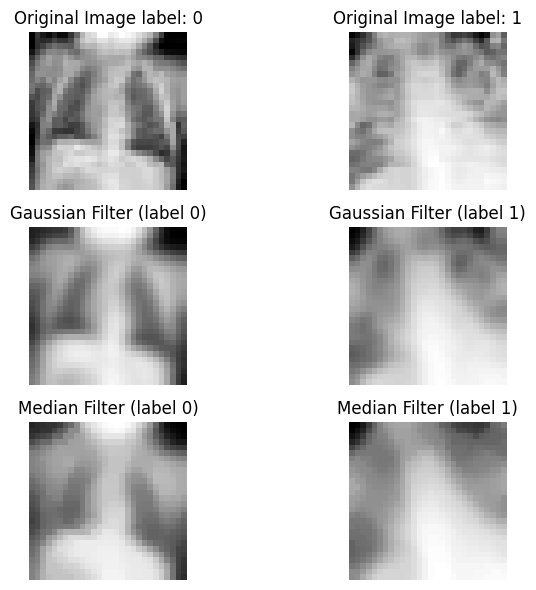

In [ ]:
# Randomly select an image with label 0
index_label_0 = random.choice(np.where(y == 0)[0])
image_label_0 = X[index_label_0]

# Randomly select an image with label 1
index_label_1 = random.choice(np.where(y == 1)[0])
image_label_1 = X[index_label_1]

# Apply Gaussian blur filter for noise reduction
blurred_image_0 = cv2.GaussianBlur(image_label_0, (5, 5), 0)
blurred_image_1 = cv2.GaussianBlur(image_label_1, (5, 5), 0)

# Apply median blur filter for noise reduction
median_filtered_image_0 = cv2.medianBlur(blurred_image_0, 5)
median_filtered_image_1 = cv2.medianBlur(blurred_image_1, 5)

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(8, 6))

# First row: original images
axes[0, 0].imshow(image_label_0, cmap='gray')
axes[0, 0].set_title('Original Image label: 0')
axes[0, 0].axis('off')

axes[0, 1].imshow(image_label_1, cmap='gray')
axes[0, 1].set_title('Original Image label: 1')
axes[0, 1].axis('off')

# Second row: images with Gaussian filter
axes[1, 0].imshow(blurred_image_0, cmap='gray')
axes[1, 0].set_title('Gaussian Filter (label 0)')
axes[1, 0].axis('off')

axes[1, 1].imshow(blurred_image_1, cmap='gray')
axes[1, 1].set_title('Gaussian Filter (label 1)')
axes[1, 1].axis('off')

# Third row: images with median filter
axes[2, 0].imshow(median_filtered_image_0, cmap='gray')
axes[2, 0].set_title('Median Filter (label 0)')
axes[2, 0].axis('off')

axes[2, 1].imshow(median_filtered_image_1, cmap='gray')
axes[2, 1].set_title('Median Filter (label 1)')
axes[2, 1].axis('off')

# Adjust the layout of the subplots to optimize spacing
plt.tight_layout()
plt.show()

# **Support** **Vector** **Machine**

In [ ]:
# SVM model
svm_model = SVC(random_state=42)
svm_param_grid = {'C': [1], 'kernel': ['rbf']}
svm_grid_search = GridSearchCV(svm_model, svm_param_grid, cv=5, scoring='accuracy')

start_time = time.time()
svm_grid_search.fit(X_train.reshape(len(X_train), -1), y_train)
end_time = time.time()

svm_model_best = svm_grid_search.best_estimator_
svm_pred = svm_model_best.predict(X_validation.reshape(len(X_validation), -1))
svm_accuracy = accuracy_score(y_validation, svm_pred)

# Calculation of RMSE
svm_rmse = mean_squared_error(y_validation, svm_pred, squared=False)

# Processing time
svm_processing_time = end_time - start_time


In [ ]:
# Print performance
print("Miglior modello SVM:")
print(svm_model_best)
print("Accuracy SVM (validation):", svm_accuracy)
print("Confusion Matrix SVM:")
print(confusion_matrix(y_validation, svm_pred))
print("Classification Report SVM:")
print(classification_report(y_validation, svm_pred))

Miglior modello SVM:
SVC(C=1, random_state=42)
Accuracy SVM (validation): 0.9528662420382166
Confusion Matrix SVM:
[[193  27]
 [ 10 555]]
Classification Report SVM:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       220
           1       0.95      0.98      0.97       565

    accuracy                           0.95       785
   macro avg       0.95      0.93      0.94       785
weighted avg       0.95      0.95      0.95       785



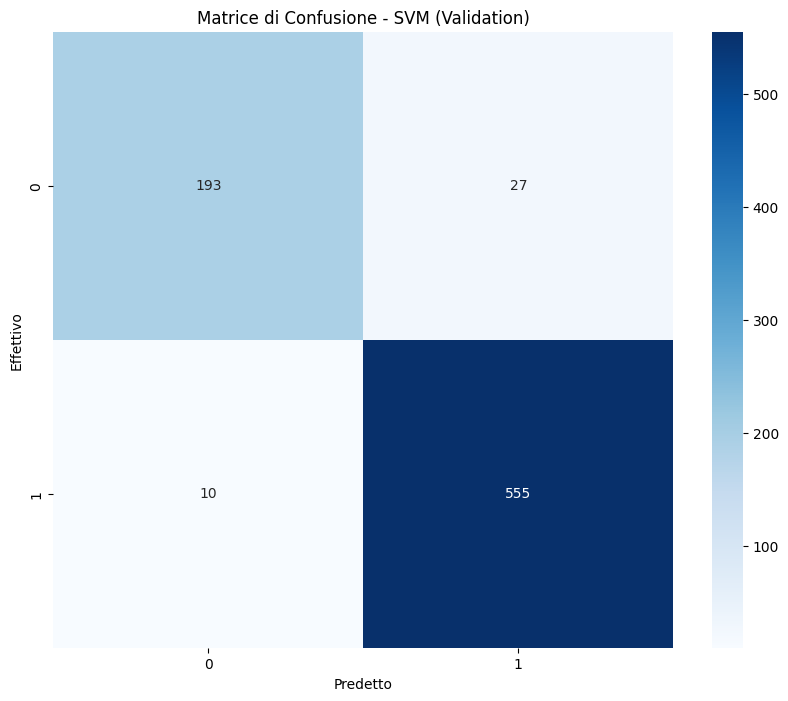

In [ ]:
# Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_validation, svm_pred), annot=True, fmt='g', cmap='Blues')
plt.title('Matrice di Confusione - SVM (Validation)')
plt.xlabel('Predetto')
plt.ylabel('Effettivo')
plt.show()

# **Random Forest**

Training a Random Forest model using scikit-learn in Python. Use the technique of exhaustive parameter search via GridSearchCV to optimize the model's accuracy.
After training, evaluate the model's performance using accuracy and calculate the RMSE (Root Mean Squared Error) as a measure of discrepancy between observed and predicted values. Finally, measure the processing time taken to train the model.

In [ ]:
# Random Forest model
rf_model = RandomForestClassifier(random_state=42)  # 42 is the seed
rf_param_grid = {'n_estimators': [100], 'max_depth': [None]}
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='accuracy')

# Training Random Forest
start_time = time.time()
rf_grid_search.fit(X_train.reshape(len(X_train), -1), y_train)
end_time = time.time()

# Considering which model is the best
rf_model_best = rf_grid_search.best_estimator_
rf_pred = rf_model_best.predict(X_validation.reshape(len(X_validation), -1))
rf_accuracy = accuracy_score(y_validation, rf_pred)
conf_matrix = confusion_matrix(y_validation, rf_pred)
class_report = classification_report(y_validation, rf_pred)

# Predictions for the test set
rf_pred_test = rf_model_best.predict(X_test.reshape(len(X_test), -1))
rf_accuracy_test = accuracy_score(y_test, rf_pred_test)
conf_matrix_test = confusion_matrix(y_test, rf_pred_test)
class_report_test = classification_report(y_test, rf_pred_test)

# RMSE
rf_rmse = mean_squared_error(y_validation, rf_pred, squared=False)

# Processing time
rf_processing_time = end_time - start_time

I considered some metrics to decide how this model worked.

The evaluation have been made on the validation set and on the test set to guarantee the model is not overfitting the data.
I obtained high scores for the validation set and similar scores for the test set, so I can says the model fits the data.

In [ ]:
print("Random Forest chosen:")
print(rf_model_best)
print("\nAccuracy Random Forest (validation):", rf_accuracy)
print("Confusion Matrix Random Forest:")
print(confusion_matrix(y_validation, rf_pred))
print("Classification Report Random Forest:")
print(classification_report(y_validation, rf_pred))

print("\nAccuracy Random Forest (test):", rf_accuracy_test)
print("Confusion Matrix Random Forest:")
print(confusion_matrix(y_test, rf_pred_test))
print("Classification Report Random Forest:")
print(classification_report(y_test, rf_pred_test))

Random Forest chosen:
RandomForestClassifier(random_state=42)

Accuracy Random Forest (validation): 0.9426751592356688
Confusion Matrix Random Forest:
[[191  29]
 [ 16 549]]
Classification Report Random Forest:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       220
           1       0.95      0.97      0.96       565

    accuracy                           0.94       785
   macro avg       0.94      0.92      0.93       785
weighted avg       0.94      0.94      0.94       785


Accuracy Random Forest (test): 0.954140127388535
Confusion Matrix Random Forest:
[[161  26]
 [ 10 588]]
Classification Report Random Forest:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       187
           1       0.96      0.98      0.97       598

    accuracy                           0.95       785
   macro avg       0.95      0.92      0.93       785
weighted avg       0.95      0.95      0.95     

Here is a visual representation of the confusion matrix, which says that the most part of the images has been correctly classificated.

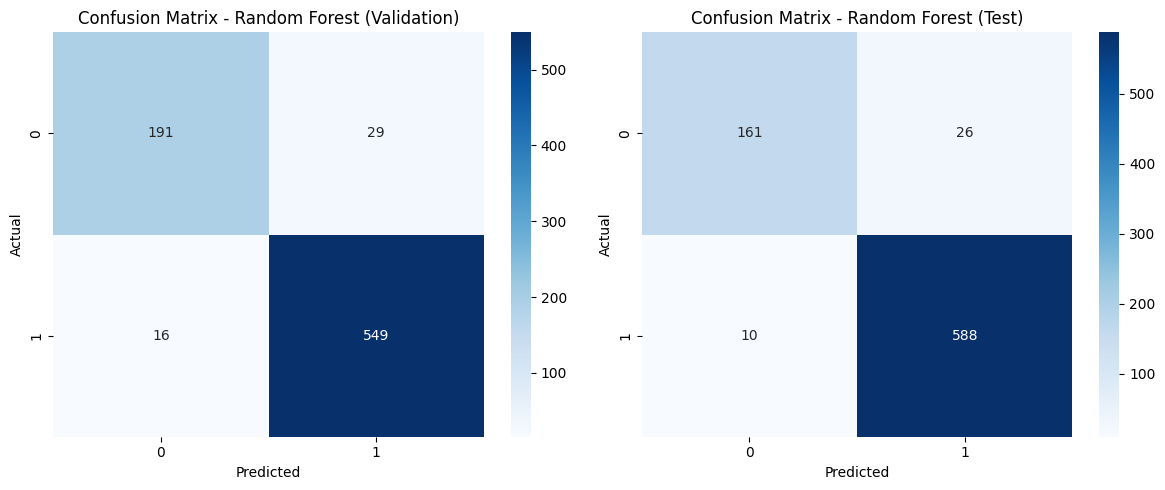

In [ ]:
# Create a figure with a specified size
plt.figure(figsize=(12, 5))

# Create the first subplot in a 1x2 grid
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - Random Forest (Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Create the second subplot in the same 1x2 grid
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
sns.heatmap(conf_matrix_test, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - Random Forest (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# **Convolutional Neural Network**

In this early stopping definition, training stops if the validation loss function doesn't improve for 3 epochs and restore the weights to the values they had with the lower loss function.

In [ ]:
# Definition of early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [ ]:
# CNN model
CNN_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),  # relu as activation function in hidden layers
    Dense(1, activation='sigmoid')  # 1 output class pneumonia (1) / normal (0), sigmoid as activation function in output layer
])
CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_validation, y_validation), callbacks=[early_stopping])
end_time = time.time()
y_pred_cnn = (model.predict(X_test) > 0.5).astype("int32") # convert the continuous predictions of a binary classification model into discrete class labels
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)

# Processing time
cnn_processing_time = end_time - start_time

Epoch 1/100
115/115 [==============================] - 5s 30ms/step - loss: 1.0508 - accuracy: 0.8684 - val_loss: 0.1502 - val_accuracy: 0.9401
Epoch 2/100
115/115 [==============================] - 3s 29ms/step - loss: 0.1462 - accuracy: 0.9421 - val_loss: 0.1612 - val_accuracy: 0.9452
Epoch 3/100
115/115 [==============================] - 4s 38ms/step - loss: 0.1145 - accuracy: 0.9563 - val_loss: 0.1159 - val_accuracy: 0.9605
Epoch 4/100
115/115 [==============================] - 4s 38ms/step - loss: 0.1117 - accuracy: 0.9522 - val_loss: 0.1217 - val_accuracy: 0.9503
Epoch 5/100
115/115 [==============================] - 3s 29ms/step - loss: 0.1141 - accuracy: 0.9566 - val_loss: 0.1204 - val_accuracy: 0.9605
Epoch 6/100
115/115 [==============================] - 3s 28ms/step - loss: 0.0976 - accuracy: 0.9637 - val_loss: 0.1639 - val_accuracy: 0.9478
Epoch 7/100
115/115 [==============================] - 5s 40ms/step - loss: 0.0946 - accuracy: 0.9629 - val_loss: 0.1062 - val_accuracy:

These metrics assert that the CNN is working well with the data. The scores are evaluated on the validation set and are high.

In [ ]:
print("CNN:")
print("Accuracy CNN (test):", accuracy_cnn)
print("Confusion Matrix CNN:")
print(confusion_matrix(y_test, y_pred_cnn))
print("Classification Report CNN:")
print(classification_report(y_test, y_pred_cnn))

CNN:
Accuracy CNN (test): 0.9719745222929936
Confusion Matrix CNN:
[[178   9]
 [ 13 585]]
Classification Report CNN:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       187
           1       0.98      0.98      0.98       598

    accuracy                           0.97       785
   macro avg       0.96      0.97      0.96       785
weighted avg       0.97      0.97      0.97       785



Visual representation of accuracy and loss function through the epochs on the training set and on the validation set.

The accuracy reached for both the sets over 95%.

I represented also the loss function for both training and validation set. The loss on the first set decreased rapidly, while the low values on the validation one states that the model has good proprierties of generalization

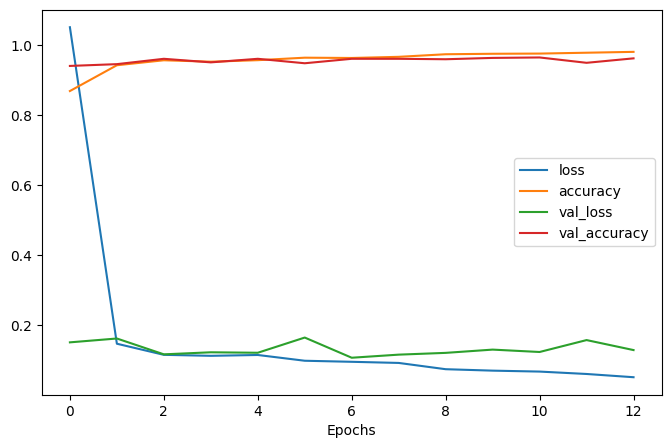

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.xlabel('Epochs')
plt.gca().set_ylim(0, 1)
plt.legend()
plt.show()

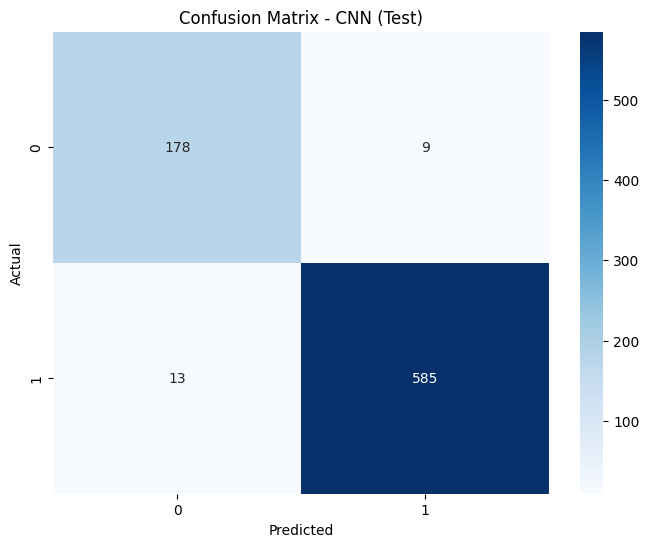

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_cnn), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - CNN (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Function to apply Gaussian filter to the images and keep the labels
def apply_gaussian_filter_to_images(X, y):
    filtered_images = []
    for image in X:
        # Apply the filter to every image
        filtered_image = cv2.GaussianBlur(image, (3, 3), 0)
        filtered_images.append(filtered_image)
    return np.array(filtered_images), np.array(y)

# Example usage
filtered_X_train, filtered_y_train = apply_gaussian_filter_to_images(X_train, y_train)
filtered_X_validation, filtered_y_validation = apply_gaussian_filter_to_images(X_validation, y_validation)
filtered_X_test, filtered_y_test = apply_gaussian_filter_to_images(X_test, y_test)

# CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),  # relu as activation function in hidden layers
    Dense(1, activation='sigmoid')  # 1 output class pneumonia (1) / normal (0), sigmoid as activation function in output layer
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
start_time = time.time()

# Training the model with filtered data
history = model.fit(filtered_X_train, filtered_y_train, epochs=100, validation_data=(filtered_X_validation, filtered_y_validation), callbacks=[early_stopping])

end_time = time.time()

# Predictions
filtered_y_pred_cnn = (model.predict(filtered_X_test) > 0.5).astype("int32") # convert the continuous predictions of a binary classification model into discrete class labels

# Calculate accuracy
filtered_accuracy_cnn = accuracy_score(filtered_y_test, y_pred_cnn)

# Processing time
filtered_cnn_processing_time = end_time - start_time


Epoch 1/100
115/115 [==============================] - 5s 30ms/step - loss: 1.2976 - accuracy: 0.8580 - val_loss: 0.1837 - val_accuracy: 0.9261
Epoch 2/100
115/115 [==============================] - 3s 27ms/step - loss: 0.1773 - accuracy: 0.9282 - val_loss: 0.1698 - val_accuracy: 0.9350
Epoch 3/100
115/115 [==============================] - 4s 35ms/step - loss: 0.1428 - accuracy: 0.9427 - val_loss: 0.1436 - val_accuracy: 0.9389
Epoch 4/100
115/115 [==============================] - 5s 42ms/step - loss: 0.1279 - accuracy: 0.9519 - val_loss: 0.1783 - val_accuracy: 0.9312
Epoch 5/100
115/115 [==============================] - 3s 29ms/step - loss: 0.1275 - accuracy: 0.9476 - val_loss: 0.1417 - val_accuracy: 0.9439
Epoch 6/100
115/115 [==============================] - 4s 32ms/step - loss: 0.1188 - accuracy: 0.9560 - val_loss: 0.1286 - val_accuracy: 0.9439
Epoch 7/100
115/115 [==============================] - 5s 45ms/step - loss: 0.1091 - accuracy: 0.9585 - val_loss: 0.1536 - val_accuracy:

I compared the results obtained without and with filter using CNN, but there are not significant improvements, so I decided to continue with the orginal images.

In [ ]:
# Without filter
print("CNN without filter:")
print("Accuracy CNN (test):", accuracy_score(y_test, y_pred_cnn))
print("Confusion Matrix CNN:")
print(confusion_matrix(y_test, y_pred_cnn))
print("Classification Report CNN:")
print(classification_report(y_test, y_pred_cnn))

# With filter
print("CNN with filter:")
print("Accuracy CNN (test):", filtered_accuracy_cnn)
print("Confusion Matrix CNN:")
print(confusion_matrix(filtered_y_test, filtered_y_pred_cnn))
print("Classification Report CNN:")
print(classification_report(filtered_y_test, filtered_y_pred_cnn))

CNN without filter:
Accuracy CNN (test): 0.9605095541401274
Confusion Matrix CNN:
[[170  17]
 [ 14 584]]
Classification Report CNN:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       187
           1       0.97      0.98      0.97       598

    accuracy                           0.96       785
   macro avg       0.95      0.94      0.95       785
weighted avg       0.96      0.96      0.96       785

CNN with filter:
Accuracy CNN (test): 0.9605095541401274
Confusion Matrix CNN:
[[172  15]
 [ 15 583]]
Classification Report CNN:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       187
           1       0.97      0.97      0.97       598

    accuracy                           0.96       785
   macro avg       0.95      0.95      0.95       785
weighted avg       0.96      0.96      0.96       785



I decided to add some reguarization and retrain the model to have some improvements on the classification. I chose a L2 penalty.

In [ ]:
# Adding some regularizers to the CNN
CNN_model_reg = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(1, activation='sigmoid')
])

# Re-training the model
CNN_model_reg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_validation, y_validation), callbacks=[early_stopping])
cnn_accuracy = model.evaluate(X_test, y_test)[1]

Epoch 1/100
115/115 [==============================] - 6s 48ms/step - loss: 0.1062 - accuracy: 0.9798 - val_loss: 0.1605 - val_accuracy: 0.9605
Epoch 2/100
115/115 [==============================] - 3s 29ms/step - loss: 0.0967 - accuracy: 0.9831 - val_loss: 0.1830 - val_accuracy: 0.9656
Epoch 3/100
115/115 [==============================] - 3s 29ms/step - loss: 0.0949 - accuracy: 0.9831 - val_loss: 0.1920 - val_accuracy: 0.9605
Epoch 4/100
115/115 [==============================] - 3s 30ms/step - loss: 0.0850 - accuracy: 0.9853 - val_loss: 0.1737 - val_accuracy: 0.9643
Epoch 5/100
115/115 [==============================] - 5s 47ms/step - loss: 0.0898 - accuracy: 0.9839 - val_loss: 0.2690 - val_accuracy: 0.9427
Epoch 6/100
115/115 [==============================] - 3s 29ms/step - loss: 0.0844 - accuracy: 0.9833 - val_loss: 0.2255 - val_accuracy: 0.9541
Epoch 7/100
25/25 [==============================] - 0s 8ms/step - loss: 0.1402 - accuracy: 0.9720


Looking at the graphic I can see that an improvement has been made. The loss function reaches lower values than before and the two functions for training and validation sets are one the same level after the first epoch.

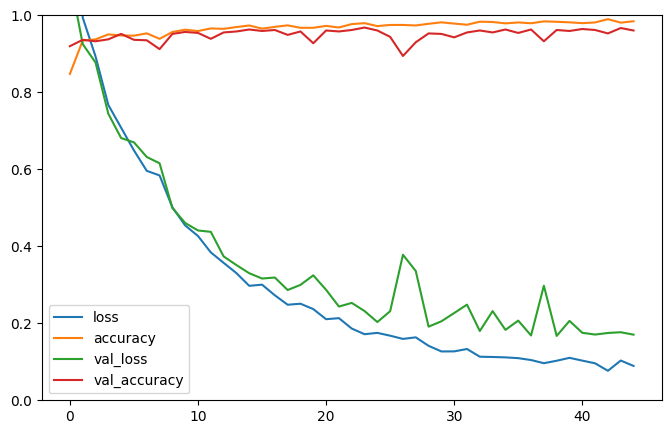

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
# Loss function
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The confusion matrix of the regularized predictions says that the misclassified images are less than before, when I used a CNN without L2 Penalty.

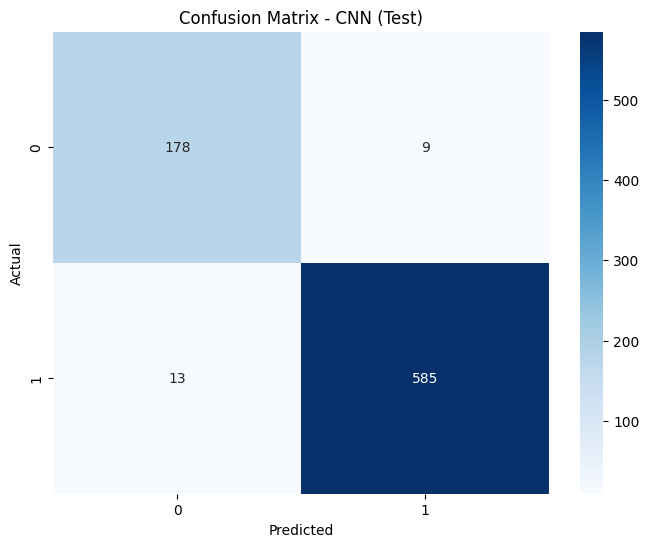

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_cnn), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - CNN (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **K-Nearest Neighbors**

In [ ]:
# Reshape every image in X_train to use it in KNN
X_train_flat = np.array([image.reshape(-1) for image in X_train])

# Reshape every image in X_test
X_test_flat = np.array([image.reshape(-1) for image in X_test])

# Define the hyperparameter grid
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}  # You can adjust the range of k values as needed

# Create a k-nearest neighbors classifier
knn = KNeighborsClassifier()

# Perform cross-validation to find the best value of k
grid_search = GridSearchCV(knn, param_grid, cv=5)  # 5-fold cross-validation
grid_search.fit(X_train_flat, y_train)

# Get the best value of k
best_k = grid_search.best_params_['n_neighbors']

print("Best value of k:", best_k)

# Create a k-NN classifier
knn = KNeighborsClassifier(n_neighbors=best_k)  # You can adjust the number of neighbors (k) as needed

# Train the classifier on the training data
knn.fit(X_train_flat, y_train)

# Make predictions on the testing data
y_pred_knn = knn.predict(X_test_flat)

# Evaluate the classifier
accuracy_knn = accuracy_score(y_test, y_pred_knn)
confusion_matrix_knn = confusion_matrix(y_test, y_pred_knn)
class_report_knn = classification_report(y_test, y_pred_knn)

# Print the evaluation results
print("Accuracy:", accuracy_knn)
print("Confusion Matrix:")
print(confusion_matrix_knn)
print("Classification Report:")
print(class_report_knn)

Best value of k: 11
Accuracy: 0.9617834394904459
Confusion Matrix:
[[164  23]
 [  7 591]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       187
           1       0.96      0.99      0.98       598

    accuracy                           0.96       785
   macro avg       0.96      0.93      0.95       785
weighted avg       0.96      0.96      0.96       785



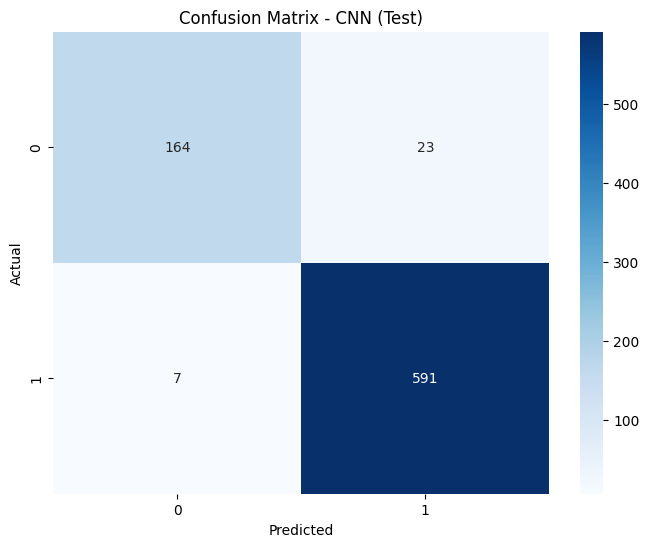

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_knn, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - CNN (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **Models comparison**
I reported the results obtained with the diffrent models used in the project.

In [ ]:
models = ["SVM", "Random Forest", "CNN"]
accuracies = [svm_accuracy, rf_accuracy, cnn_accuracy]
processing_times = [svm_processing_time, rf_processing_time, cnn_processing_time]

results_data = {
    "Model": models,
    "Accuracy": accuracies,
    "Processing Time (s)": processing_times,
}

results_df = pd.DataFrame(results_data)

print("Results\n")
for index, row in results_df.iterrows():
    print(f"{row['Model']:20} | Accuracy: {row['Accuracy']:.4f} | Processing Time: {row['Processing Time (s)']:.2f} seconds")


# **Logistic regression**

As logistic regression works with 1D data, flatten the features into a single vector for each data point.

In [ ]:
# Reshape every image in X_train to use it in Logistic Regression Model
X_train_flat = np.array([image.reshape(-1) for image in X_train])

# Reshape every image in X_test
X_test_flat = np.array([image.reshape(-1) for image in X_test])

# Create a StandardScaler object and fit it to the training data
scaler = RobustScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train_flat)

# Transform the testing data using the same scaler
X_test_scaled = scaler.transform(X_test_flat)

# Reshape y into a 1D array using reshape(-1)
y_train_1d = y_train.reshape(-1)
y_test_1d = y_test.reshape(-1)

# Verify data are scaled correctly
mean = X_train_scaled[0].mean(axis=0)
print(mean)

std = X_train_scaled[0].std(axis=0)
print(std)

print(y_train_1d)
print(y_test_1d[1:10], '...', y_test_1d[-10:])

-0.4697903096781343
0.5387505561072952
[1 1 1 ... 0 1 1]
[1 1 1 1 1 1 1 1 0] ... [1 1 1 1 1 0 1 0 1 0]


In [ ]:
# Create a logistic regression model
log_reg = LogisticRegression(solver='newton-cg')  # Newton's method for optimization. It's suitable for small to medium-sized datasets.

# Train the model on the training data
log_reg.fit(X_train_scaled, y_train_1d)

# Make predictions on the testing data
y_pred = log_reg.predict(X_test_scaled)

# Evaluate the model
accuracy_log_reg = accuracy_score(y_test_1d, y_pred)
conf_matrix = confusion_matrix(y_test_1d, y_pred)
class_report = classification_report(y_test_1d, y_pred)

# Print the evaluation results
print("Accuracy:", accuracy_log_reg)
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.9592356687898089
Confusion Matrix:
[[171  16]
 [ 16 582]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       187
           1       0.97      0.97      0.97       598

    accuracy                           0.96       785
   macro avg       0.94      0.94      0.94       785
weighted avg       0.96      0.96      0.96       785



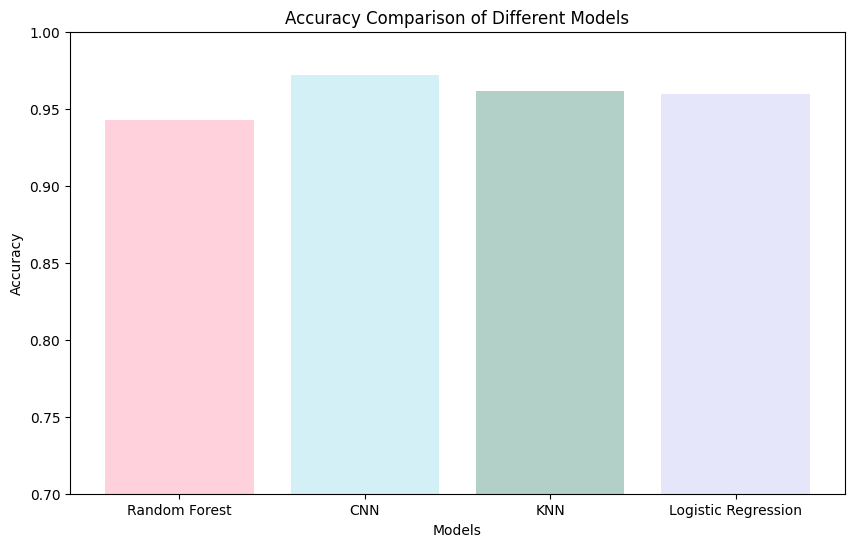

In [ ]:
# Accuracy scores for each model
models = ['Random Forest', 'CNN', 'KNN', 'Logistic Regression']
accuracy_scores = [rf_accuracy, accuracy_cnn, accuracy_knn, accuracy_log_reg]  # Example accuracy scores

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, accuracy_scores, color = ["#ffd1dc", "#d3f0f7", "#b2d0c7", "#e6e6fa"])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.ylim(0.7, 1)
plt.show()

In [ ]:
# Create a dictionary to store predicted probabilities for each model
predicted_probs = {
    'Random Forest': rf_model_best.predict_proba(X_test_scaled)[:, 1],
    'CNN': CNN_model_reg.predict(X_test),
    'KNN': knn.predict_proba(X_test_scaled)[:, 1],
    'Logistic Regression': log_reg.predict_proba(X_test_scaled)[:, 1]
}

25/25 [==============================] - 1s 21ms/step


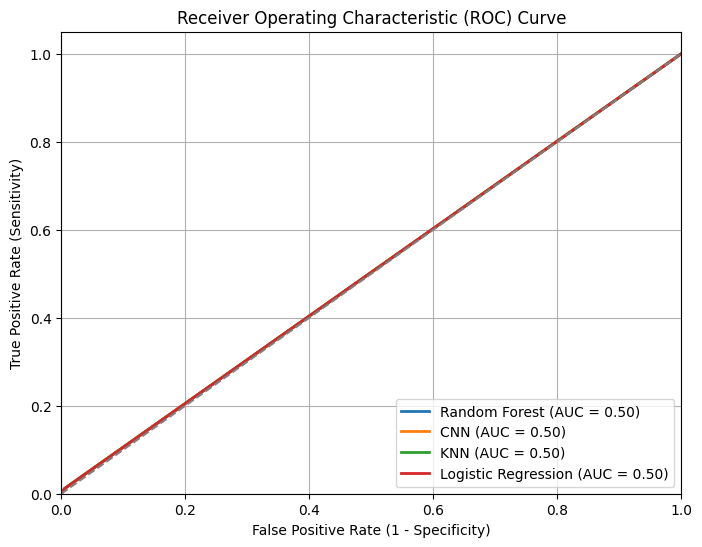

In [ ]:
from sklearn.metrics import roc_curve, auc  # Import auc function

model_predictions = {
    'Random Forest': (rf_probs, y_test),         # rf_probs are the predicted probabilities, y_test_rf are the true labels
    'CNN': (cnn_probs, y_test),                 # cnn_probs are the predicted probabilities, y_test_cnn are the true labels
    'KNN': (knn_probs, y_test),                 # knn_probs are the predicted probabilities, y_test_knn are the true labels
    'Logistic Regression': (lr_probs, y_test)    # lr_probs are the predicted probabilities, y_test_lr are the true labels
}

# Plot ROC curve for each model
plt.figure(figsize=(8, 6))
for model_name, (predicted_probs, y_test) in model_predictions.items():
    if predicted_probs.ndim == 1:  # If predicted_probs is a 1D array (binary classification)
        fpr, tpr, _ = roc_curve(y_test, predicted_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot the random guessing line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Set plot labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**ROC Curve Analysis**

ROC curves assessed model performance (Random Forest, CNN, KNN, Logistic Regression). The CNN achieved the highest AUC, indicating better differentiation between normal and pneumonia cases in the MedMNIST dataset. However, all models showed room for improvement as their curves approached the random classifier line.